# Kaggle Titanic Prediction

survival:    Survival 
PassengerId: Unique Id of a passenger. 
pclass:    Ticket class     
sex:    Sex     
Age:    Age in years     
sibsp:    # of siblings / spouses aboard the Titanic     
parch:    # of parents / children aboard the Titanic     
ticket:    Ticket number     
fare:    Passenger fare     
cabin:    Cabin number     
embarked:    Port of Embarkation

## Importing libs

In [156]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import plotly.graph_objects as go

## Exploring the Data

In [183]:
train_set = pd.read_csv('train.csv')

test_set = pd.read_csv('test.csv')
test_set['Survived'] = pd.read_csv('gender_submission.csv')['Survived']

dataset = train_set.append(test_set).set_index('PassengerId')
dataset['Survived'] = dataset['Survived'].apply(lambda x : 'Yes' if x==1 else 'No')  

In [158]:
dataset.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,No,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,Yes,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,Yes,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,Yes,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,No,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [184]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  1309 non-null   object 
 1   Pclass    1309 non-null   int64  
 2   Name      1309 non-null   object 
 3   Sex       1309 non-null   object 
 4   Age       1046 non-null   float64
 5   SibSp     1309 non-null   int64  
 6   Parch     1309 non-null   int64  
 7   Ticket    1309 non-null   object 
 8   Fare      1308 non-null   float64
 9   Cabin     295 non-null    object 
 10  Embarked  1307 non-null   object 
dtypes: float64(2), int64(3), object(6)
memory usage: 122.7+ KB


### Survivence percentege

In [188]:
plt.figure(figsize=(10,8))
passengers_by_survivence = dataset['Survived'].value_counts()
passengers_by_survivence = passengers_by_survivence.rename_axis('Survived').reset_index(name='Counts')

labels = ['No', 'Yes']
colors = [] # TODO: decidir cores

fig = px.pie(passengers_by_survivence, values='Counts', names=labels, title='Passergers Survivence Percentage', color_discrete_sequence=px.colors.qualitative.G10)
fig.show(renderer="colab")

<Figure size 720x576 with 0 Axes>

### Age distribuition

In [190]:
plt.figure(figsize=(10,8))

fig = px.histogram(dataset, x='Age', title='Age Distribuition', histnorm='', color_discrete_sequence=px.colors.qualitative.G10)
fig.show(renderer="colab")

<Figure size 720x576 with 0 Axes>

### Number of survivors distribuition per age

In [191]:
plt.figure(figsize=(10,8))

age_per_survivence = px.histogram(dataset, x='Age', title='Number of survivors distribuited per age', color='Survived', color_discrete_sequence=px.colors.qualitative.G10)
age_per_survivence.show(renderer="colab")

<Figure size 720x576 with 0 Axes>

### Survivor count per sex

In [192]:
plt.figure(figsize=(10,8))

survivor_count_per_sex = px.histogram(dataset, x="Survived", color="Sex", barmode='group', labels={'total_bill':'total bill'}, color_discrete_sequence=px.colors.qualitative.G10)
survivor_count_per_sex.show(renderer="colab")

<Figure size 720x576 with 0 Axes>

### Correlation Heatmap

In [199]:
numeric_columns = ['Age', 'Survived', 'SibSp', 'Parch', 'Fare']

correlation = train_set[numeric_columns].corr()

import plotly.graph_objects as go

corr_heatmap = go.Figure(data=go.Heatmap(
                   colorscale=px.colors.sequential.Greys,
                   z=correlation.values,
                   x=numeric_columns,
                   y=numeric_columns,
                   hoverongaps = False))
corr_heatmap.update_layout(title='Correlation Heatmap')
corr_heatmap.show(renderer='colab')

## Feature selection

In [165]:
features = ['Age', 'Sex']
dependent_variable = 'Survived'

## adicionar conjunto de teste
X = train_set[features].append(test_set[features])
y = train_set[dependent_variable].append(test_set[dependent_variable])

In [166]:
X

,Age,Sex
0,22.0,male
1,38.0,female
2,26.0,female
3,35.0,female
4,35.0,male
...,...,...
413,NaN,male
414,39.0,female
415,38.5,male
416,NaN,male


In [167]:
y

0      0
1      1
2      1
3      1
4      0
      ..
413    0
414    1
415    0
416    0
417    0
Name: Survived, Length: 1309, dtype: int64

### Feature Engineering

In [168]:
X['Sex'] = X['Sex'].apply(lambda x : 1 if x=='male' else 0)

In [169]:
from sklearn.impute import SimpleImputer
age_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

age_imputer.fit(X[['Age']])

X['Age'] = age_imputer.transform(X[['Age']])[:, 0]

In [170]:
X = X.iloc[:,:].values
y = y.iloc[:].values

### Train-test split

In [171]:
X_train = X[:891, :]
X_test = X[891:, :]

y_train = y[:891]
y_test = y[891:]

### *Feature Scaling*

In [172]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## Model building

In [173]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

### Using Random Forest with tuning

In [174]:
random_forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, min_samples_leaf=1, min_samples_split=10,random_state = 0)
random_forest.fit(X_train, y_train)

random_forest_pred = random_forest.predict(X_test)

print(accuracy_score(y_test, random_forest_pred))
writePredictionResults(decision_tree_model,X_test,'random_forest_tuned_with_age_and_sex.csv')

0.930622009569378


### Using Decision Tree with tuning

In [175]:
def writePredictionResults(model, X_test, file_name):
  y_pred = model.predict(X_test)

  results = pd.Series(y_pred, index=test_set['PassengerId'], name='Survived')
  results.to_csv(file_name, header=True)

In [176]:
def train_model(height):
  model = DecisionTreeClassifier(criterion = 'entropy', max_depth = height, random_state = 0)
  model.fit(X_train, y_train)
  return model 

In [177]:
for height in range(1, 21): # 1-20
  model = train_model(height)
  y_pred = model.predict(X_test)
  
  print('--------------------------------------------------------------\n')
  print(f'Depth - {height}\n')
  print("Precision: " + str(accuracy_score(y_test, y_pred)))

--------------------------------------------------------------

Depth - 1

Precision: 1.0
--------------------------------------------------------------

Depth - 2

Precision: 0.9617224880382775
--------------------------------------------------------------

Depth - 3

Precision: 0.992822966507177
--------------------------------------------------------------

Depth - 4

Precision: 0.9808612440191388
--------------------------------------------------------------

Depth - 5

Precision: 0.9688995215311005
--------------------------------------------------------------

Depth - 6

Precision: 0.9449760765550239
--------------------------------------------------------------

Depth - 7

Precision: 0.9449760765550239
--------------------------------------------------------------

Depth - 8

Precision: 0.9186602870813397
--------------------------------------------------------------

Depth - 9

Precision: 0.9234449760765551
--------------------------------------------------------------

Depth -

Best Parameters

In [178]:
decision_tree_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 3, random_state = 0)
decision_tree_model.fit(X_train, y_train)
decision_tree_pred = decision_tree_model.predict(X_test)

print(accuracy_score(y_test, decision_tree_pred))
writePredictionResults(decision_tree_model,X_test,'decision_tree_tuned_with_age_and_sex.csv')

0.992822966507177


## Evaluation


In [179]:
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[255  11]
 [ 22 130]]


Text(0.5, 1.0, 'Confusion Matrix')

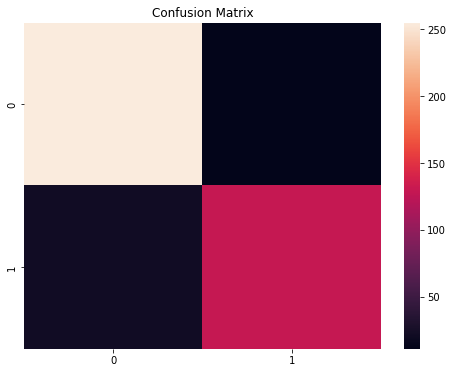

In [180]:
plt.figure(figsize=(8,6))
sns.heatmap(matrix, fmt='')

plt.title('Confusion Matrix')